# 0. Импорт библиотек

In [1]:
import pandas as pd
from pandas import Series
import numpy as np


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import collections
        
import warnings
warnings.filterwarnings("ignore")

/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv
/kaggle/input/sf-dst-scoring/sample_submission.csv


# 1. Импорт данных

In [2]:
train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
train.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


- **client_id** - идентификатор клиента
- **education** - уровень образования
- **sex** - пол заемщика
- **age** - возраст заемщика
- **car** - флаг наличия автомобиля
- **car_type** - флаг автомобиля иномарки
- **decline_app_cnt** - количество отказанных прошлых заявок
- **good_work** - флаг наличия “хорошей” работы
- **bki_request_cnt** - количество запросов в БКИ
- **home_address** - категоризатор домашнего адреса
- **work_address** - категоризатор рабочего адреса
- **income** - доход заемщика
- **foreign_passport** - наличие загранпаспорта
- **sna** - связь заемщика с клиентами банка
- **first_time** - давность наличия информации о заемщике
- **score_bki** - скоринговый балл по данным из БКИ
- **region_rating** - рейтинг региона
- **app_date** - дата подачи заявки
- **default** - флаг дефолта по кредиту

## 1.1 Краткая информация о датасетах

In [3]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

(None, None)

In [4]:
train.columns, test.columns

(Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport', 'default'],
       dtype='object'),
 Index(['client_id', 'app_date', 'education', 'sex', 'age', 'car', 'car_type',
        'decline_app_cnt', 'good_work', 'score_bki', 'bki_request_cnt',
        'region_rating', 'home_address', 'work_address', 'income', 'sna',
        'first_time', 'foreign_passport'],
       dtype='object'))

## 1.2 Пропуски в датасете

In [5]:
train.isnull().sum(), test.isnull().sum()

(client_id             0
 app_date              0
 education           307
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 default               0
 dtype: int64,
 client_id             0
 app_date              0
 education           171
 sex                   0
 age                   0
 car                   0
 car_type              0
 decline_app_cnt       0
 good_work             0
 score_bki             0
 bki_request_cnt       0
 region_rating         0
 home_address          0
 work_address          0
 income                0
 sna                   0
 first_time            0
 foreign_passport      0
 dtype: int64)

### Заполним пропуски самым частым значением

In [6]:
cont_1 = collections.Counter(train['education'])
cont_2 = collections.Counter(test['education'])

train['education'].fillna(cont_1.most_common()[0][0], inplace=True)
test['education'].fillna(cont_2.most_common()[0][0], inplace=True)

## 1.3 Даты

### Приведем формат даты в удобный вид

In [7]:
train.app_date = pd.to_datetime(train.app_date)
test.app_date = pd.to_datetime(train.app_date)
display(train.head(2))
display(test.head(2))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,2014-02-01,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,2014-03-12,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


### Создание новых признаков на основе дат

In [8]:
current_date = pd.to_datetime('18OCT2020')

# Создание признака "Количество прошедших дней"

train['days_passed'] = (current_date - train.app_date).dt.days
test['days_passed'] = (current_date - test.app_date).dt.days

# Создание признака "Месяц подачи заявки"
train['app_date_month'] = train.app_date.dt.month
test['app_date_month'] = test.app_date.dt.month

## 1.4 Итоговая группировка признаков

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   client_id         73799 non-null  int64         
 1   app_date          73799 non-null  datetime64[ns]
 2   education         73799 non-null  object        
 3   sex               73799 non-null  object        
 4   age               73799 non-null  int64         
 5   car               73799 non-null  object        
 6   car_type          73799 non-null  object        
 7   decline_app_cnt   73799 non-null  int64         
 8   good_work         73799 non-null  int64         
 9   score_bki         73799 non-null  float64       
 10  bki_request_cnt   73799 non-null  int64         
 11  region_rating     73799 non-null  int64         
 12  home_address      73799 non-null  int64         
 13  work_address      73799 non-null  int64         
 14  income            7379

In [10]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['app_date_month', 'education', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

# 2. Визуализация данных

### Недефолтных клиентов гораздо больше, что говорит о неравномерности выборки

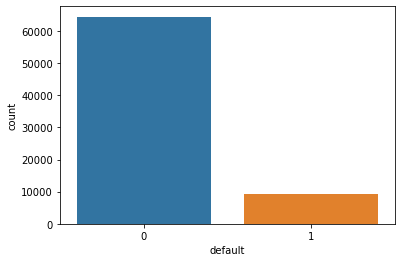

In [11]:
display(sns.countplot(train['default']))

## 2.1 Графики численных признаков

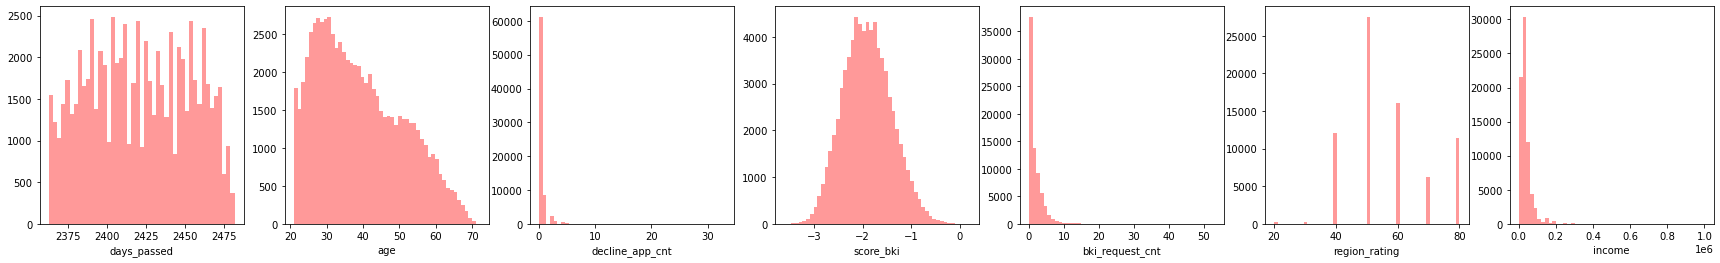

In [12]:
fig, axes = plt.subplots(1, 7, figsize=(30,4))
for col, i in zip(num_cols, range(7)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i], color="r")

### Прологарифмируем переменные со странным распределением

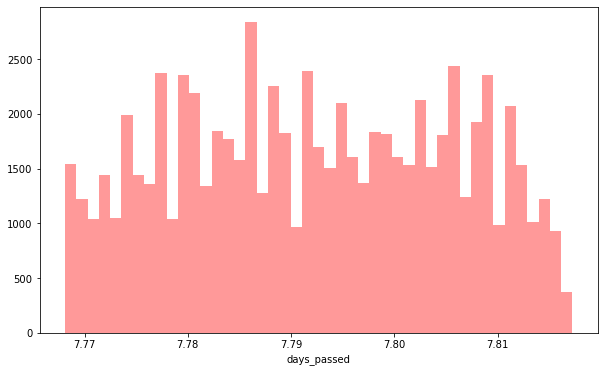

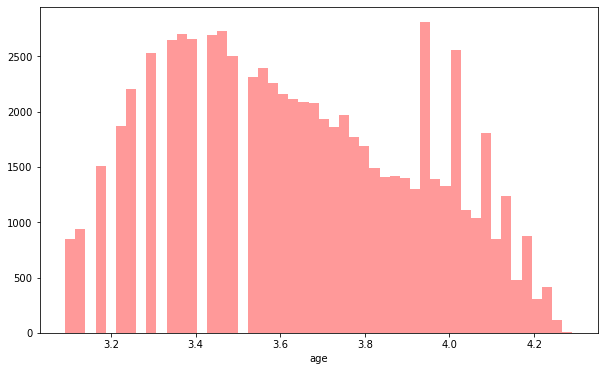

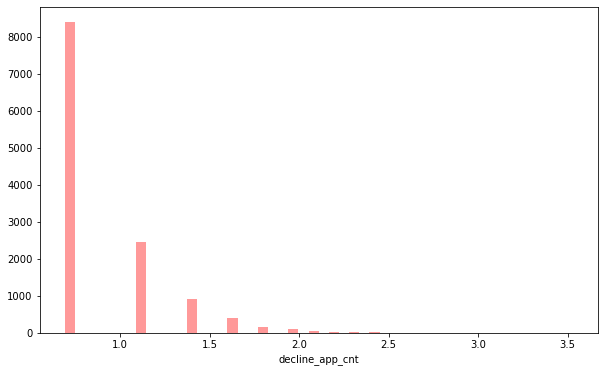

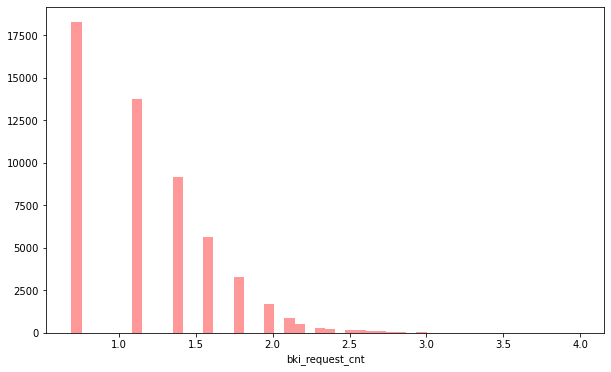

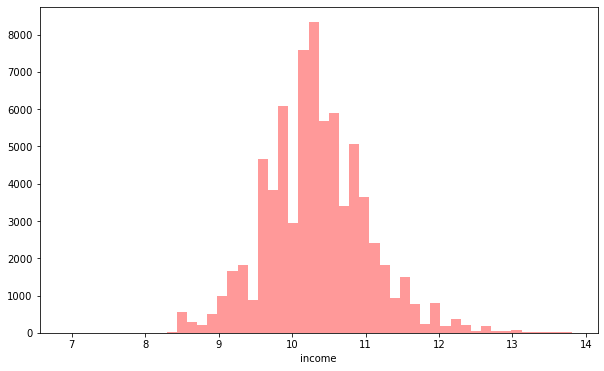

In [13]:
num_cols_log = ['days_passed', 'age', 'decline_app_cnt', 'bki_request_cnt', 'income']
for i in num_cols_log:
    train[i] = np.log(train[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(train[i][train[i] > 0].dropna(), kde = False, rug=False, color="r")
    plt.show()

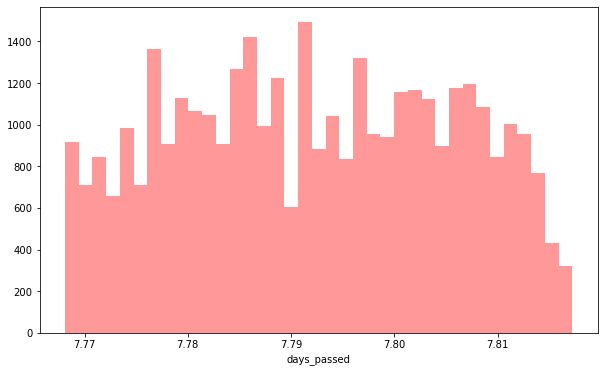

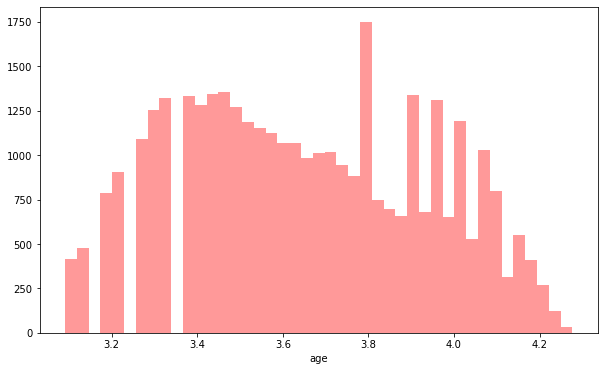

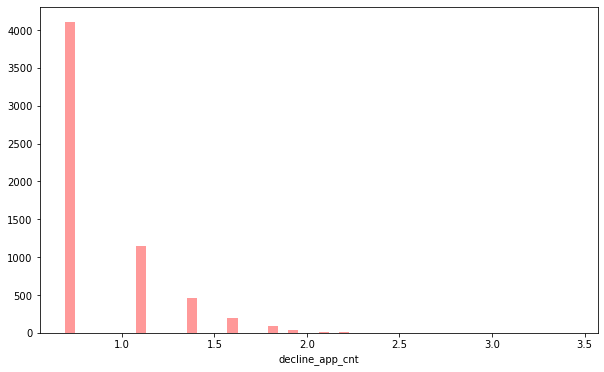

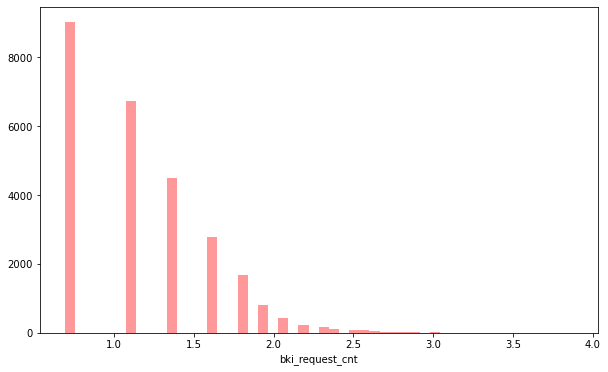

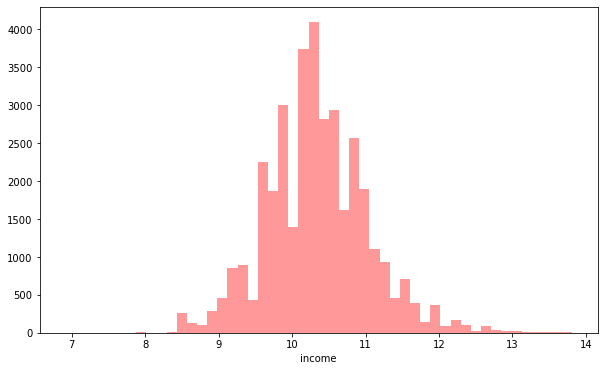

In [14]:
for i in num_cols_log:
    test[i] = np.log(test[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(test[i][test[i] > 0].dropna(), kde = False, rug=False, color="r")
    plt.show()

### Боксплоты для численных переменных (days_passed, age, decline_app_cnt, score_bki, bki_request_cnt, region_rating, income)

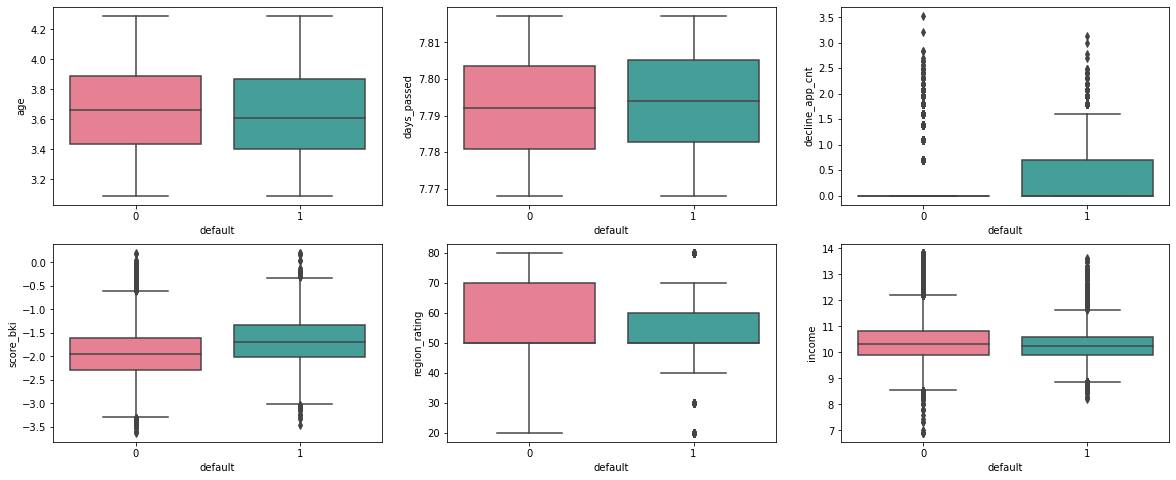

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(20,8))

sns.boxplot(x=train.default, y=train.age, ax=axes.flat[0], palette='husl')
sns.boxplot(x=train.default, y=train.days_passed, ax=axes.flat[1],palette='husl')
sns.boxplot(x=train.default, y=train.decline_app_cnt, ax=axes.flat[2],palette='husl')
sns.boxplot(x=train.default, y=train.score_bki, ax=axes.flat[3],palette='husl')
sns.boxplot(x=train.default, y=train.region_rating, ax=axes.flat[4],palette='husl')
sns.boxplot(x=train.default, y=train.income, ax=axes.flat[5],palette='husl')


### Выводы по боксплотам:
**1 boxplot:** Недефолтные клиенты в среднем старше дефолтных;  
**2 boxplot:** Дефолтные клиенты в среднем оформляли заявки раньше, чем недефолтные, разница не значительная для вывода;  
**3 boxplot:** У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных;  
**4 boxplot:** Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно;  
**5 boxplot:** Среднее значение в данном случае больше у недефолтных клиентов, при этом медианы равны;  
**6 boxplot:** Доход недефолтных клиентов выше, чем доход дефолтных.  

### Работа с выбросами

По результату boxplot(ов) выше необходимо очистить от выбросов следующие признаки:  
1. decline_app_cnt  
2. score_bki  
3. region_rating  
4. income

# 25% квартиль для признаков
Q1_decline_app_cnt = train['decline_app_cnt'].quantile(q=0.25, interpolation='midpoint')
Q1_score_bki = train['score_bki'].quantile(q=0.25, interpolation='midpoint')
Q1_region_rating = train['region_rating'].quantile(q=0.25, interpolation='midpoint')
Q1_income = train['income'].quantile(q=0.25, interpolation='midpoint')

# 75% квартиль для признаков
Q3_decline_app_cnt = train['decline_app_cnt'].quantile(q=0.75, interpolation='midpoint')
Q3_score_bki = train['score_bki'].quantile(q=0.75, interpolation='midpoint')
Q3_region_rating = train['region_rating'].quantile(q=0.75, interpolation='midpoint')
Q3_income = train['income'].quantile(q=0.75, interpolation='midpoint')

# межквартильный размах для признаков
IQR_decline_app_cnt = Q3_decline_app_cnt - Q1_decline_app_cnt
IQR_score_bki = Q3_score_bki - Q1_score_bki
IQR_region_rating = Q3_region_rating - Q1_region_rating
IQR_income = Q3_income - Q1_income

print('Доля выбросов по признаку decline_app_cnt от общего массива: ',round(100*len(train['decline_app_cnt'][(train.decline_app_cnt > (Q3_decline_app_cnt + 1.5*IQR_decline_app_cnt)) | (train.decline_app_cnt<(Q1_decline_app_cnt - 1.5*IQR_decline_app_cnt))])/len(train),2),'%')
print('Доля выбросов по признаку score_bki от общего массива: ',round(100*len(train['score_bki'][(train.score_bki > (Q3_score_bki + 1.5*IQR_score_bki)) | (train.score_bki<(Q1_score_bki - 1.5*IQR_score_bki))])/len(train),2),'%')
print('Доля выбросов по признаку region_rating от общего массива: ',round(100*len(train['region_rating'][(train.region_rating > (Q3_region_rating + 1.5*IQR_region_rating)) | (train.region_rating<(Q1_region_rating - 1.5*IQR_region_rating))])/len(train),2),'%')
print('Доля выбросов по признаку income от общего массива: ',round(100*len(train['income'][(train.income > (Q3_income + 1.5*IQR_income)) | (train.income<(Q1_income - 1.5*IQR_income))])/len(train),2),'%')

train = train.loc[-((train.decline_app_cnt > (Q3_decline_app_cnt + 1.5 * IQR_decline_app_cnt)) | (train.decline_app_cnt < (Q1_decline_app_cnt - 1.5 * IQR_decline_app_cnt)))]
len(train)

train = train.loc[-((train.score_bki > (Q3_score_bki + 1.5 * IQR_score_bki)) | (train.score_bki < (Q1_score_bki - 1.5 * IQR_score_bki)))]
len(train)

train = train.loc[-((train.region_rating > (Q3_region_rating + 1.5 * IQR_region_rating)) | (train.region_rating < (Q1_region_rating - 1.5 * IQR_region_rating)))]
len(train)

train = train.loc[-((train.income > (Q3_income + 1.5 * IQR_income)) | (train.income < (Q1_income - 1.5 * IQR_income)))]
len(train)

### Матрица корреляций: высокой корреляции между признаками не наблюдается

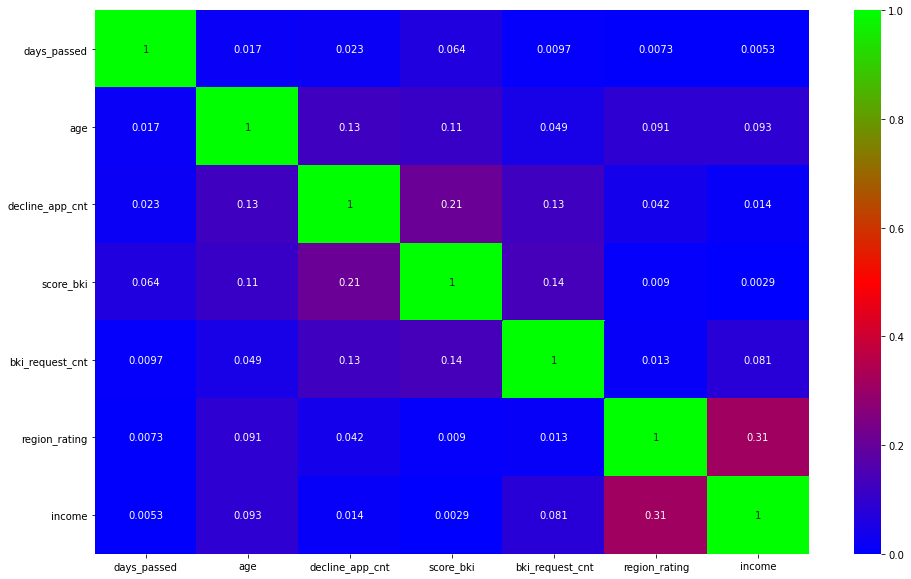

In [16]:
plt.figure(figsize=(16,10))
sns.heatmap(train[num_cols].corr().abs(), vmin=0, vmax=1, annot=True, cmap = 'brg')

## 2.2 Бинарные и категориальные признаки

### Преобразуем бинарные переменные при помощи класса LabelEncoder

In [17]:
label_encoder = LabelEncoder()

for column in bin_cols:
    train[column] = label_encoder.fit_transform(train[column])
    test[column] = label_encoder.fit_transform(test[column])

display(train.head(2))
display(test.head(2))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,days_passed,app_date_month
0,25905,2014-02-01,SCH,1,4.143135,1,1,0.0,0,-2.008753,...,50,1,2,9.798183,4,1,0,0,7.804659,2
1,63161,2014-03-12,SCH,0,4.094345,0,0,0.0,0,-1.532276,...,50,2,3,9.852247,4,1,0,0,7.788626,3


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,days_passed,app_date_month
0,74835,2014-02-01,GRD,1,3.401197,1,1,0.000000,0,-2.271884,1.386294,50,1,2,10.819798,1,4,0,7.804659,2
1,17527,2014-03-12,SCH,0,3.688879,0,0,1.791759,0,-1.504999,1.098612,50,1,2,8.517393,4,3,0,7.788626,3


### Преобразуем категориальные переменные при помощи OneHotEncoder

In [18]:
x_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)
y_cat = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)

print(x_cat.shape)
print(y_cat.shape)

(73799, 23)
(36349, 23)


### Преобразовываем признак education

In [19]:
train_education = pd.get_dummies(train['education'])
train_education.head(2)

,ACD,GRD,PGR,SCH,UGR
0,0,0,0,1,0
1,0,0,0,1,0


## 2.3 Значимость численных признаков

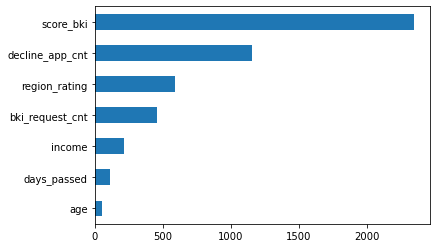

In [20]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## 2.4 Значимость бинарных и категориальных признаков

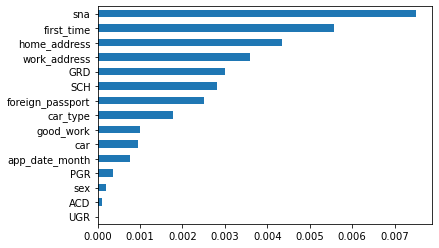

In [21]:
edu_cat_cols = ['app_date_month', 'home_address', 'work_address', 'sna', 'first_time']

imp_cat_bin = pd.Series(mutual_info_classif(pd.concat([train[edu_cat_cols+bin_cols], train_education], axis=1),
                                        train['default'], discrete_features =True),
                    index = pd.concat([train[edu_cat_cols+bin_cols], train_education], axis=1).columns)
imp_cat_bin.sort_values(inplace = True)
imp_cat_bin.plot(kind = 'barh')

### Выводы о значимости:
1. Признак score_bki и sna - имеют огромный вес;
2. Признаки sex и age - не имеют особого значения;
3. Признак GRD имеет наибольшее влияние из всех типов признака education.

# 3. Подготовка данных к ML

In [22]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train[num_cols].values)
y_test = poly.fit_transform(test[num_cols].values)

## 3.1 Стандартизация численных признаков

In [23]:
x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)
print(x_num)
print(y_num)

[[ 0.          0.93588253  1.71113664 ... -0.56439672 -0.64537197
  -0.7868588 ]
 [ 0.         -0.27295273  1.5399884  ... -0.56439672 -0.62789392
  -0.71429225]
 [ 0.          0.93588253 -1.39343857 ...  1.91366223  1.51939095
  -0.08530891]
 ...
 [ 0.         -1.56503033 -0.66507223 ...  1.91366223  1.72911286
   0.49692694]
 [ 0.          1.79196515 -0.89146325 ... -0.56439672 -0.75056844
  -1.21518657]
 [ 0.          1.21211344 -0.35072683 ... -0.56439672 -0.53917737
  -0.33979532]]
[[ 0.          0.93953565 -0.88333898 ... -0.56902243 -0.31968854
   0.65637674]
 [ 0.         -0.27355575  0.12606863 ... -0.56902243 -1.06274348
  -2.40227913]
 [ 0.          0.93953565  0.97850869 ... -0.56902243 -0.48454293
  -0.0850894 ]
 ...
 [ 0.         -1.37903871 -0.65688874 ... -0.56902243 -0.260849
   0.92970115]
 [ 0.         -0.46192364 -1.12541848 ...  1.90270276  1.51166781
  -0.0850894 ]
 [ 0.         -1.1249291   0.0372345  ... -0.56902243 -0.70823148
  -1.03384706]]


## 3.2 Объединение всех данных в единый формат

In [24]:
# Merge

X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test.client_id
test = np.hstack([y_num, test[bin_cols].values, y_cat])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle = True)

# 4. Регуляризация

In [26]:
from sklearn.model_selection import GridSearchCV

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучший penalty: l2
Лучшее C: 7.742636826811269


# 5. Обучение модели

In [27]:
lgr = LogisticRegression(penalty = 'l2', C=166.81005372000593, max_iter=500)
lgr.fit(X_train, y_train)

LogisticRegression(C=166.81005372000593, max_iter=500)

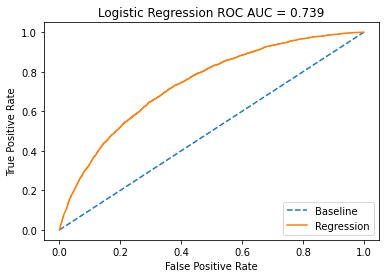

In [28]:
probs = lgr.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## 5.1 Обучим модель на всем датасете

In [29]:
lgr = LogisticRegression(penalty = 'l2', C=166.81005372000593, max_iter=500)
lgr.fit(X, Y)
probs = lgr.predict_proba(test)
probs = probs[:,1]

In [30]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
my_submission.to_csv('submission.csv', index=False)

my_submission

,client_id,default
0,74835,0.050151
1,17527,0.380070
2,75683,0.079487
3,26883,0.078358
4,28862,0.011679
...,...,...
36344,83775,0.410242
36345,106254,0.017182
36346,81852,0.267835
36347,1971,0.195066
